In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

In [3]:
df = pd.read_csv('../data/external/data.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

Text(0.5, 0, 'Count')

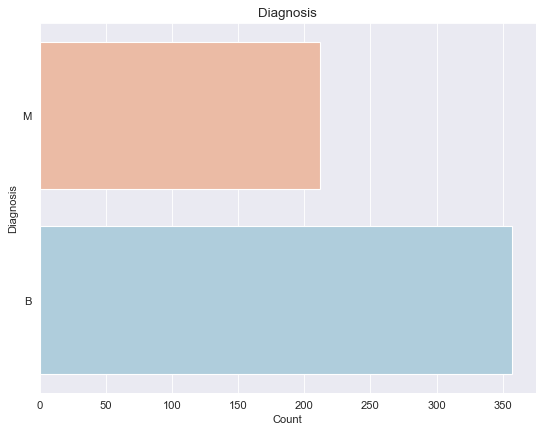

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(df['diagnosis'], palette='RdBu')

plt.title('Diagnosis')
plt.ylabel('Diagnosis')
plt.xlabel('Count')

## Oversampling

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

In [7]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_rus, y_rus = rus.fit_resample(X, y)

y_rus.value_counts()

diagnosis
B    212
M    212
Name: count, dtype: int64

Text(0.5, 0, 'Count')

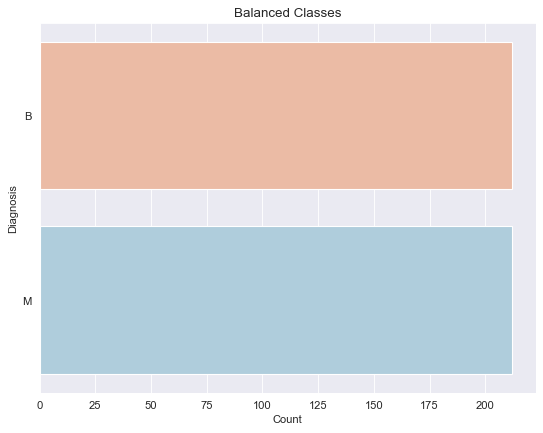

In [8]:
plt.figure(figsize=(8, 6))

sns.countplot(y_rus, palette='RdBu')

plt.title('Balanced Classes')
plt.ylabel('Diagnosis')
plt.xlabel('Count')

## Data Transformation

In [9]:
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5)),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((339, 30), (85, 30))

## Model Training

In [10]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9647058823529412

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.98      0.96      0.97        46
           M       0.95      0.97      0.96        39

    accuracy                           0.96        85
   macro avg       0.96      0.97      0.96        85
weighted avg       0.97      0.96      0.96        85



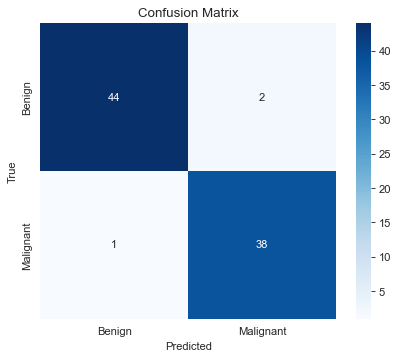

In [12]:
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True,
    cmap='Blues',
    fmt='g',
    square=True,
    xticklabels=['Benign', 'Malignant'],
    yticklabels=['Benign', 'Malignant']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__n_neighbors': np.arange(1, 10),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
}

grid = GridSearchCV(clf, params, cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 7,
 'classifier__weights': 'uniform'}

In [14]:
clf.set_params(**grid.best_params_)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9647058823529412

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.98      0.96      0.97        46
           M       0.95      0.97      0.96        39

    accuracy                           0.96        85
   macro avg       0.96      0.97      0.96        85
weighted avg       0.97      0.96      0.96        85



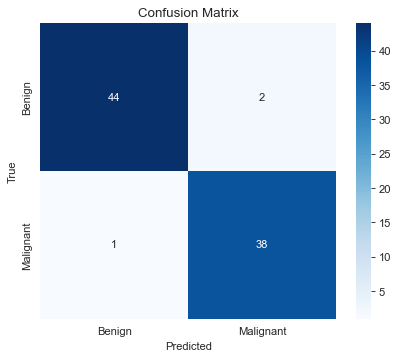

In [16]:
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True,
    cmap='Blues',
    fmt='g',
    square=True,
    xticklabels=['Benign', 'Malignant'],
    yticklabels=['Benign', 'Malignant']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print(round(accuracy_score(y_test, y_pred), 2))

0.96
